# FOMO - Faster Objects, More Objects

### Import modules

In [15]:
import pytorch_lightning as pl
import torch

from pathlib import Path
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision.io import read_image
from torchvision.transforms import Resize

### BoundingBoxToMask

In [16]:
class BoundingBoxToMask():
    def __init__(self, image_resolution: int, grid_scale: int):
        self._image_resolution = image_resolution
        self._grid_scale = grid_scale

    def __call__(self, bounding_box_file):
        grid_resolution = int(self._image_resolution / self._grid_scale)
        mask = torch.zeros((grid_resolution, grid_resolution), dtype=int)  # 0 in that mask stands for background, next values represent corresponding classes
        bounding_boxes = bounding_box_file.readlines()
        for bounding_box in bounding_boxes:
            [c, x, y, w, h] = [float(coords) for coords in bounding_box.split()]  # get bounding box class, position and dimension
            xp = int((x + (w / 2)) * self._image_resolution)  # calculate center of bounding box
            yp = int((y + (h / 2)) * self._image_resolution)
            xp_idx = int(xp / self._grid_scale)  # calculate cell coordinates, with center of bounding box 
            yp_idx = int(yp / self._grid_scale)
            mask[yp_idx, xp_idx] = c + 1  # mark cell containing center of bounding box, with class value increased by 1
        return mask

### Dataset

In [17]:
class VehicleDataset(Dataset):
    def __init__(self, dataset_dir: Path, subset: list[str], transform=None, target_transform=None):
        self._images = [dataset_dir / 'images' / (element + ".jpg") for element in subset]
        self._bounding_boxes = [dataset_dir / 'bounding_boxes' / (element + ".txt") for element in subset]
        self._transform = transform
        self._target_transform = target_transform
    
    def __getitem__(self, idx: int):
        image_path = self._images[idx]
        image = read_image(str(image_path))
        image = self._transform(image)

        bounding_box_path = self._bounding_boxes[idx]
        bounding_box_file = open(bounding_box_path)
        mask = self._target_transform(bounding_box_file)        

        return image, mask

    def __len__(self):
        return len(self._images)

### DataModule

In [18]:
class VehicleDataModule(pl.LightningDataModule):
    def __init__(self, dataset_dir: Path, input_resolution: int, grid_scale: int = 8, batch_size: int = 32):
        super().__init__()
        self._dataset_dir = dataset_dir
        self._input_resolution = input_resolution   # model input image resolution (assume input is squared shape)
        self._grid_scale = grid_scale  # number of pixels per cell on prediction grid (vertically and horizontally)
        self._batch_size = batch_size
        
        self._transform = Resize((input_resolution, input_resolution), antialias=True)
        self._target_transform = BoundingBoxToMask(input_resolution, grid_scale)
        self._train_dataset = None
        self._val_dataset = None

    def setup(self, stage: str):
        data_names = sorted([data_name for data_name in (self._dataset_dir / 'images').iterdir()])
        train_names, val_names = random_split(data_names, [0.85, 0.15])
        self._train_dataset = VehicleDataset(self._dataset_dir, [data_names[idx].stem for idx in train_names.indices], self._transform, self._target_transform)
        self._val_dataset = VehicleDataset(self._dataset_dir, [data_names[idx].stem for idx in val_names.indices], self._transform, self._target_transform)
        
    def train_dataloader(self):
        return DataLoader(self._train_dataset, batch_size=self._batch_size)

    def val_dataloader(self):
        return DataLoader(self._val_dataset, batch_size=self._batch_size)

### TESTS

In [19]:
DATASET_DIR = Path('vehicle_detection_dataset')
IMAGE_RESOLUTION = int(1280 / 4)
GRID_SCALE = 8

In [20]:
vehicle_data_module = VehicleDataModule(dataset_dir=DATASET_DIR, input_resolution=IMAGE_RESOLUTION, grid_scale=GRID_SCALE)
vehicle_data_module.setup(stage=None)
train_loader = vehicle_data_module.train_dataloader()
data = next(iter(train_loader))

There are 13 objects in the picture


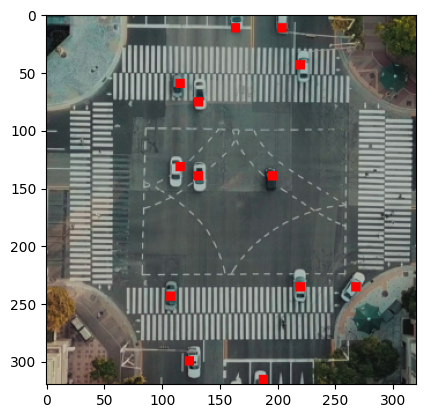

In [21]:
import matplotlib.pyplot as plt
import cv2
import numpy as np

data_idx = 0
image = data[0][data_idx]
mask = data[1][data_idx]

image = image.permute(1, 2, 0).numpy()
mask = mask.numpy()

mask_res = cv2.resize(mask, dsize=(IMAGE_RESOLUTION, IMAGE_RESOLUTION), interpolation=cv2.INTER_NEAREST)
image[mask_res == 1] = [255, 0, 0]
plt.imshow(image)

cnt = np.count_nonzero(mask == 1)
print("There are", str(cnt), "objects in the picture")